In [88]:
import os
import warnings
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import theano.tensor as tt
import matplotlib.pyplot as plt
from itertools import permutations
from sklearn.mixture import GaussianMixture
%matplotlib notebook

In [2]:
K = 3
NUM_VARS = 3 * K + 1
warnings.filterwarnings('ignore')

In [3]:
class Functions:
    def __init__(self):
        pass

    def make_cov_matrix(self, sigma=None, corr=None, chol=None, module=np):
        if chol is None:
            C = module.ones((2, 2))
            var = module.diag(sigma)
            idxu = np.triu_indices(2, 1)
            idxl = np.tril_indices(2, -1)
            if module == np:
                C[idxu] = corr
                C[idxl] = corr
            else:
                C = tt.set_subtensor(C[idxu], corr)
                C = tt.set_subtensor(C[idxl], corr)
            cov = var.dot(C).dot(var)
        else:
            C = module.zeros((2, 2))
            idxl = np.mask_indices(2, np.tril)
            if module == np:
                C[idxl] = chol
            else:
                C = tt.set_subtensor(C[idxl], chol)
            cov = C.dot(C.T)
        return cov

    def sampling(self, w, mu, cov, N=1000):
        num = int(w * N)
        if len(mu) == 1:
            samples = np.random.normal(mu, cov, size=num)
        else:
            samples = np.random.multivariate_normal(mu, cov, size=num)
        return samples

    def flatten(self, input_list):
        output_list = []
        while True:
            if input_list == []:
                break
            for index, i in enumerate(input_list):
                if type(i) == list:
                    input_list = i + input_list[index + 1:]
                    break
                else:
                    output_list.append(i)
                    input_list.pop(index)
                    break
        return output_list

    def norm_1d(self, x, mu, sigma):
        prob = np.zeros(x.shape[0])
        for i, v in enumerate(x):
            prob[i] = 1 / (np.sqrt(2 * 3.14 * sigma ** 2)) * np.exp(-0.5 * (v - mu) ** 2 / sigma ** 2)
        return prob

    def norm_2d(self, x, w, mu, cov):
        prob = np.zeros(x.shape[0])
        for i, v in enumerate(x):
            c = [np.sqrt(1 / ((2 * 3.14) ** 2 * np.linalg.det(cov[k]))) for k in range(K)]
            f = [c[k] * np.exp(-0.5 * (v - mu[k]).dot(np.linalg.inv(cov[k])).dot((v - mu[k]).T)) for k in range(K)]
            prob[i] = np.sum([w[k] * f[k] for k in range(K)])
        return prob

    def cluster(self, x, w, mu, cov):
        prob = np.zeros([x.shape[0], K])
        cluster = np.zeros(x.shape[0])
        for i, v in enumerate(x):
            c = [np.sqrt(1 / ((2 * 3.14) ** 2 * np.linalg.det(cov[k]))) for k in range(K)]
            f = [c[k] * np.exp(-0.5 * (v - mu[k]).dot(np.linalg.inv(cov[k])).dot((v - mu[k]).T)) for k in range(K)]
            for k in range(K):
                prob[i, k] = w[k] * f[k]
            cluster[i] = prob[i].argmax()
        return cluster

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def stocGraAscent(self, data, label):
        m, n = np.shape(data)
        w = np.ones([n, 1])
        alpha = 0.01
        gamma = 2
        episode = 1000
        mini_batch = 1000
        w_trace = [w]
        loss = []
        for i in range(episode):
            dataIndex = np.random.choice(m, mini_batch, False)
            lr = 0.001
            pred = self.sigmoid(data[dataIndex].dot(w)).T
            real = label[dataIndex]
            # error = self.sigmoid(data[dataIndex].dot(w)).T - label[dataIndex]
            error = -real * alpha * (1 - pred) ** gamma * np.log(pred+1e-5) - \
                    (1 - real) * (1 - alpha) * pred ** gamma * np.log(1 - pred+1e-5)
            crossentropyloss = np.sum([-y * np.log(x) - (1 - y) * np.log(1 - x) for x, y in zip(pred, real)])
            # if mse <= 1e-3:
            #     break
            # else:
            w = w - lr * data[dataIndex].T.dot(error.T)
            w_trace.append(w)
            loss.append(crossentropyloss)
        w_trace = np.hstack(w_trace)
        return w_trace
    
    def normalization(self, x):
        return (x - x.min(0)) / (x.max(0) - x.min(0))

In [4]:
class LoadData:
    def __init__(self):
        self.data = self.read_file()

    def read_file(self):
        header_1 = ['time', 'headway', 'ttc', 'num', 'speed']
        header_2 = ['time', 'maneuver', 'lat', 'lon', 'duration', 'th']
        time = []
        hs = []
        manu = []
        for drivers in ['D1/', 'D2/', 'D3/', 'D4/', 'D5/', 'D6/']:
            for root, dirs, file in os.walk('./UAH/'+drivers):
                for path in dirs:
                    detection = pd.read_csv(os.path.join(root, path, 'PROC_VEHICLE_DETECTION.txt'), sep='\s+', names=header_1)
                    event = pd.read_csv(os.path.join(root, path, 'EVENTS_LIST_LANE_CHANGES.txt'), sep='\s+', names=header_2)
                    time_1 = np.around(detection['time'].values, 1)
                    time_2 = np.around(event['time'].values, 1)
                    headway = detection['headway'].values
                    t = np.arange(time_1[0], time_1[-1], 0.1)
                    s = np.interp(t, time_1, headway)
                    index = []
                    for d in time_2:
                        index.append(np.where(np.abs(t - d) <= 1e-3)[0][0])
                    m = np.zeros_like(t)
                    m[index] = np.sign(event['maneuver'].values)
                    time.append(t)
                    hs.append(s)
                    manu.append(m)
        time = np.concatenate(time)
        hs = np.concatenate(hs)
        manu = np.concatenate(manu)
        x0, dx0, m0 = self.grad(time, hs, manu)
        return x0, dx0, m0

    def grad(self, t, x, m):
        def outlier(s, x, level=1):
            mean_x = np.mean(s)
            std_x = np.std(s)
            index = np.where(np.abs(s - mean_x) >= level * std_x)
            x = [np.delete(x[k], index) for k in range(len(x))]
            return x

        def kalman(obs, x, p=np.eye(2), dt=0.1):
            eta = []
            for i in range(len(obs)):
                A = np.array([[1, dt], [0, 1]])
                C = np.array([[1, 0]])
                Q = 100 * np.eye(2)
                R = 1
                x = A.dot(x)
                p = A.dot(p).dot(A.T) + Q
                k = p.dot(C.T).dot(np.linalg.inv(C.dot(p).dot(C.T) + R))
                x = x + k.dot(obs[i] - C.dot(x))
                p = (np.eye(2) - k.dot(C)).dot(p)
                eta.append(x[1])
            return np.array(eta)

        headway = []
        speed = []
        maneuver = []
        i_0 = []
        i_f = []
        for i in range(len(x) - 1):
            if x[i] == -1 and x[i + 1] != -1:
                i_0.append(i)
            if x[i] != -1 and x[i + 1] == -1:
                i_f.append(i)
        num = np.min([len(i_0), len(i_f)])
        for i in range(num):
            if len(x[i_0[i] + 1: i_f[i] + 1]) < 2:
                continue
            s = x[i_0[i] + 1: i_f[i] + 1]
            ds1 = np.gradient(x[i_0[i] + 1: i_f[i] + 1], t[i_0[i] + 1: i_f[i] + 1])
            ds2 = kalman(s, np.array([s[0], ds1[0]]))
            headway.append(s)
            speed.append(ds2)
            maneuver.append(m[i_0[i] + 1: i_f[i] + 1])
        headway = np.concatenate(headway)
        speed = np.concatenate(speed)
        maneuver = np.concatenate(maneuver)
        headway, speed, maneuver = outlier(headway, (headway, speed, maneuver), 1)
        headway, speed, maneuver = outlier(speed, (headway, speed, maneuver), 1)
        return headway, speed, maneuver

    def prior_samples(self, percent=0.1):
        data_size = len(self.data[0])
        num = int(data_size * percent)
        index = np.random.choice(data_size, num, False)
        # index = range(num)
        x = self.data[0][index]
        dx = self.data[1][index]
        m = self.data[2][index]
        data_prior = pd.DataFrame([x, dx]).transpose()
        data_prior = data_prior.dropna(axis=0)
        data_prior.columns = ['x', 'dx']
        return data_prior, m

In [5]:
class BayesianGMM(Functions):
    def __init__(self, data):
        super(BayesianGMM, self).__init__()
        self.model = pm.Model()
        self.modeling(data)

    def modeling(self, data):
        with self.model:
            w = pm.Dirichlet('w', a=np.ones(K))
            mu = [pm.Normal('mu'+str(k), mu=[20, 0], sd=10, shape=2) for k in range(K)]
            sigma = [pm.HalfNormal('sigma'+str(k), sd=5, shape=2) for k in range(K)]
            corr = [pm.Uniform('corr'+str(k), lower=-1, upper=1, shape=1) for k in range(K)]
            cov = [self.make_cov_matrix(sigma=sigma[k], corr=corr[k], module=tt) for k in range(K)]
            dist = [pm.MvNormal.dist(mu=mu[k], cov=cov[k]) for k in range(K)]
            obs = pm.Mixture('obs', w=w, comp_dists=dist, observed=data)

    def training(self, advi=False):
        with self.model:
            if advi:
                inference = pm.fit(method='advi')
                trace = inference.sample()
            else:
                trace = pm.sample(chains=1)
        pm.summary(trace)
        return trace

    def plot(self, trace, type=0):
        with self.model:
            if type == 0:
                pm.traceplot(trace)
            elif type == 1:
                pm.plot_posterior(trace)
            elif type == 2:
                pm.forestplot(trace)
            elif type == 3:
                pm.autocorrplot(trace)
            elif type == 4:
                pm.energyplot(trace)
            elif type == 5:
                pm.densityplot(trace)
            else:
                pass

In [95]:
class PostProcess(Functions):
    def __init__(self, data, m, trace):
        super(PostProcess, self).__init__()
        self.data = data
        self.trace = trace
        self.m = m
        self.var, self.var_mu, self.var_std, self.var_name = self.stats()
        self.w = [self.var_mu[0][k] for k in range(K)]
        self.mu = [self.var_mu[k + 1] for k in range(K)]
        self.cov = [self.make_cov_matrix(sigma=self.var_mu[k + 1 + K], corr=self.var_mu[k + 1 + 2 * K]) for k in range(K)]
        self.gmm = GaussianMixture(K).fit(data)
        

    def stats(self):
        order = np.argsort(self.trace['w'].mean(0))
        var_name = [['mu'+str(k) for k in order], ['sigma'+str(k) for k in order], ['corr'+str(k) for k in order]]
        var_name = self.flatten(var_name)
        var = [np.vstack([self.trace['w'][:, k] for k in order]).T]
        var_mu = [var[0].mean(0)]
        var_std = [var[0].std(0)]
        for name in var_name:
            var.append(self.trace[name])
            var_mu.append(self.trace[name].mean(0))
            var_std.append(self.trace[name].std(0))
        var_name.insert(0, 'w')
        return var, var_mu, var_std, var_name

    def post_samples(self, N=1000):
        samples = [self.sampling(self.w[k], self.mu[k], self.cov[k], N) for k in range(K)]
        fig = plt.figure()
        plt.subplot(121)
        [plt.scatter(samples[k][:, 0], samples[k][:, 1], label='component'+str(k)) for k in range(K)]
        plt.legend()
        plt.xlim([5, 45])
        plt.ylim([-30, 30])
        plt.subplot(122)
        data_post = np.concatenate(samples)
        p = self.cluster(data_post, self.w, self.mu, self.cov)
        plt.scatter(data_post[:, 0], data_post[:, 1], c=p)
        plt.xlim([5, 45])
        plt.ylim([-30, 30])
        fig.savefig('./img/post_samples.svg', format='svg')
        data_post = pd.DataFrame(data_post)
        data_post.columns = ['x', 'dx']
        return data_post

    def joint_dist(self, data_post):
        sns.jointplot('x', 'dx', data=self.data, xlim=[5, 45], ylim=[-30, 30], kind='kde', space=0, color='r')
        sns.jointplot('x', 'dx', data=data_post, xlim=[5, 45], ylim=[-30, 30], kind='kde', space=0, color='g')

    def marginalized_dist(self, data_post):
        fig = plt.figure()
        plt.subplot(121)
        sns.distplot(self.data['x'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Prior distribution')
        sns.distplot(data_post['x'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Posterior distribution')
        plt.legend()
        plt.xlim([5, 45])
        plt.subplot(122)
        sns.distplot(self.data['dx'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Prior distribution')
        sns.distplot(data_post['dx'], bins=30, kde=False, norm_hist=True,
                     hist_kws={'histtype': 'step', 'linewidth': 3}, label='Posterior distribution')
        plt.legend()
        plt.xlim([-30, 30])
        fig.savefig('./img/marginalized_dist.svg', format='svg')

    def ordered(self):
        order = list(permutations(range(K)))
        mse = np.zeros(len(order))
        list_order = [0, 1, 4, 7, 2, 5, 8, 3, 6, 9]
        for n, l in enumerate(order):
            var = [self.gmm.weights_]
            for k in l:
                var.append(self.gmm.means_[k])
                sdx = np.sqrt(self.gmm.covariances_[k][0][0])
                sdy = np.sqrt(self.gmm.covariances_[k][1][1])
                var.append(np.array([sdx, sdy]))
                corr = np.array([self.gmm.covariances_[k][1][0] / (sdx * sdy)])
                var.append(corr)
            gmm_map = [var[k] for k in list_order]
            value = 0.
            for i in range(len(gmm_map)):
                for (x, y) in zip(self.var_mu, gmm_map):
                    value += np.sum((x - y) ** 2)
            mse[n] = value
        index = mse.argmin()
        var = [self.gmm.weights_]
        for k in order[index]:
            var.append(self.gmm.means_[k])
            sdx = np.sqrt(self.gmm.covariances_[k][0][0])
            sdy = np.sqrt(self.gmm.covariances_[k][1][1])
            var.append(np.array([sdx, sdy]))
            corr = np.array([self.gmm.covariances_[k][1][0] / (sdx * sdy)])
            var.append(corr)
        gmm_map = [var[k] for k in list_order]
        return gmm_map

    def compare_1d(self):
        gmm_map = self.ordered()
        fig = plt.figure()
        for i in range(NUM_VARS):
            plt.subplot2grid([int(NUM_VARS/2), 2], [int(i%(NUM_VARS/2)), int(i/(NUM_VARS/2))])
            plt.ylabel('Frequency')
            plt.title(self.var_name[i])
            col = self.var[i].shape[1]
            x = [np.linspace(self.var[i][:, k].min(), self.var[i][:, k].max(), 50) for k in range(col)]
            p = [self.norm_1d(x[k], self.var_mu[i][k], self.var_std[i][k]) for k in range(col)]
            p_max = [p[k].max() for k in range(col)]
            [plt.plot(x[k], p[k]) for k in range(col)]
            [plt.plot([gmm_map[i][k], gmm_map[i][k]], [0, p_max[k]], color='r') for k in range(col)]
        fig.savefig('./img/compare_1d.svg', format='svg')

    def compare_2d(self):
        p1 = self.norm_2d(self.data.values, self.gmm.weights_, self.gmm.means_, self.gmm.covariances_)
        p2 = self.norm_2d(self.data.values, self.w, self.mu, self.cov)
        p1 = p1 / np.sum(p1)
        p2 = p2 / np.sum(p2)
        fig = plt.figure()
        plt.subplot(121)
        plt.scatter(self.data['x'], self.data['dx'], c=p1)
        plt.colorbar()
        plt.xlim([5, 45])
        plt.ylim([-30, 30])
        plt.subplot(122)
        plt.scatter(self.data['x'], self.data['dx'], c=p2)
        plt.colorbar()
        plt.xlim([5, 45])
        plt.ylim([-30, 30])
        fig.savefig('./img/compare_2d.svg', format='svg')
        return p1
    
    def density_contour(self, level=50):
        x = np.linspace(5, 45, 50)
        y = np.linspace(-30, 30, 50)
        x, y = np.meshgrid(x, y)
        z = np.zeros([50, 50])
        for i in range(50):
            for j in range(50):
                a = np.array([[x[i][j], y[i][j]]])
                z[i][j] = p.norm_2d(a, p.w, p.mu, p.cov)
        plt.figure()
        plt.contour(x, y, z, level)
        plt.scatter(data_prior['x'].iloc[m!=0], data_prior['dx'].iloc[m!=0], c='r')

    def step(self):
        plt.figure(1)
        for i in range(NUM_VARS):
            plt.subplot2grid([int(NUM_VARS/2), 2], [int(2*i/NUM_VARS), int(2*i%NUM_VARS)])
            plt.ylabel('Frequency')
            plt.title(self.var_name[i])
            col = self.var[i].shape[1]
            x = [np.linspace(self.var[i][:, k].min(), self.var[i][:, k].max(), 50) for k in range(col)]
            p = [self.norm_1d(x[k], self.var_mu[i][k], self.var_std[i][k]) for k in range(col)]
            [plt.plot(x[k], p[k]) for k in range(col)]
            
    def maneuver(self):
        N = self.data.shape[0]
        # index = np.random.choice(self.data.shape[0], N, True, prob)
        index = range(self.data.shape[0])
        samples = self.data.iloc[index]
        s = self.m[index]
        c = self.cluster(samples.values, self.w, self.mu, self.cov)
        fig = plt.figure()
        for i in range(K):
            plt.subplot(131+i)
            plt.scatter(samples['x'].iloc[c==i], samples['dx'].iloc[c==i], alpha=0.1)
            index1 = np.where(c == i)[0]
            index1 = np.random.choice(index1, 100000)
            index2 = np.where(s != 0)[0]
            index = list(set(index1) & set(index2))
            plt.scatter(samples['x'].iloc[index], samples['dx'].iloc[index], c='r')
            plt.xlim([5, 45])
            plt.ylim([-30, 30])
            print(len(index) / len(index1))
        fig.savefig('./img/importance_sampling.svg', format='svg')
        
    def logit_classify(self):
        w_trace = self.stocGraAscent(self.data.values, self.m)
        return w_trace
    
    def importance_sampling(self, prob):
        index = range(self.data.shape[0])
        samples = self.data.iloc[index]
        s = self.m[index]
        c = self.cluster(samples.values, self.w, self.mu, self.cov)
        N = [100, 500, 1000, 5000, 10000, 50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000,
             900000, 1000000, 2000000, 3000000, 4000000, 5000000]        
        rate = np.zeros([K, len(N)])
        r = np.zeros(len(N))
        for i in range(K):
            for j, n in enumerate(N):
                index = np.where(c == i)[0]
                p = prob[index] / np.sum(prob[index])
                ix = np.random.choice(index, n, True, p)
                samples = self.data.iloc[ix]
                s = self.m[ix]
                m = np.where(s != 0)[0]
                rate[i, j] = len(m) / n
        plt.figure()
        for i in range(K):
            plt.subplot(311+i)
            plt.title('component'+str(i))
            plt.plot(range(len(N)), rate[i], label='lane changing rate')
            plt.plot(range(len(N)), rate[i][-1] * np.ones(len(N)), c='r', linestyle='--', label='expectation')
        plt.legend()
        r = [np.sum(rate[:, k] * self.w) for k in range(len(N))]
        plt.figure()
        plt.plot(range(len(N)), r, label='lane changing rate')
        plt.plot(range(len(N)), r[-1] * np.ones(len(N)), c='r', linestyle='--', label='expectation')
        plt.legend()
        return rate[:, -1]
    
    def importance_sampling1(self, prob):
        index = range(self.data.shape[0])
        samples = self.data.iloc[index]
        s = self.m[index]
        N = [100, 500, 1000, 5000, 10000, 50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 
            900000, 1000000, 2000000, 3000000, 4000000, 5000000]
        rate = np.zeros(len(N))
        for j, n in enumerate(N):
            p = prob / np.sum(prob)
            ix = np.random.choice(index, n, True, p)
            samples = self.data.iloc[ix]
            s = self.m[ix]
            m = np.where(s != 0)[0]
            rate[j] = len(m) / n
        plt.figure()
        plt.plot(range(len(N)), rate, label='lane changing rate')
        plt.plot(range(len(N)), rate[-1] * np.ones(len(N)), c='r', linestyle='--', label='expectation')
        plt.legend()
        return rate[-1]
    
    def entropy(self, x, y):
        x = self.normalization(x)
        p = x / x.sum(0)
        return p

In [8]:
# PERCENT = np.arange(0.1, 1., 0.1)
# PERCENT = np.linspace(0.1, 0.1, 10)
PERCENT = 1
d = LoadData()
data_prior, m = d.prior_samples(PERCENT)
f = BayesianGMM(data_prior)
trace = f.training()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [corr2, corr1, corr0, sigma2, sigma1, sigma0, mu2, mu1, mu0, w]
100%|██████████| 1000/1000 [06:33<00:00,  3.76it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [97]:
p = PostProcess(data_prior, m, trace)

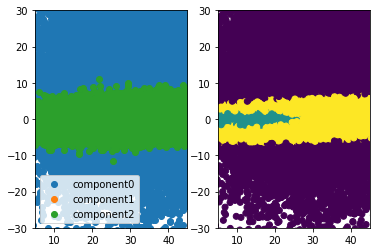

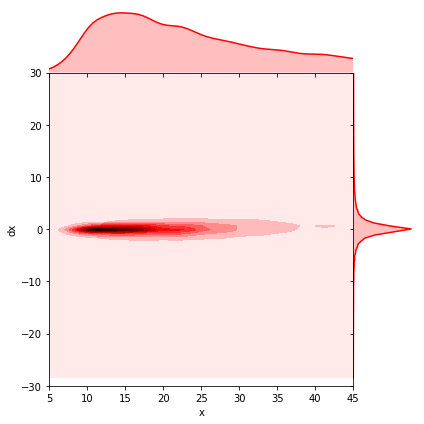

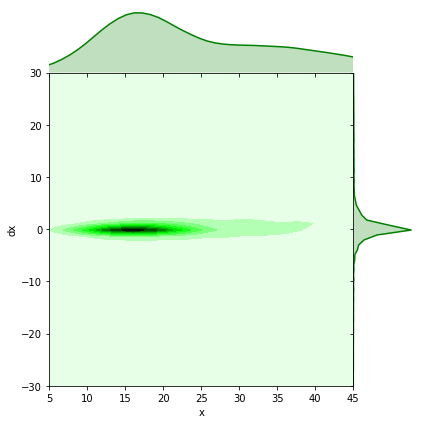

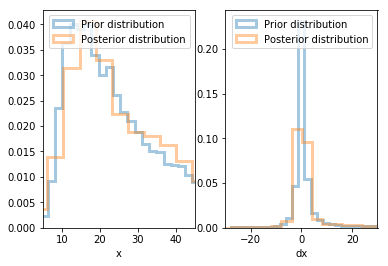

In [10]:
data_post = p.post_samples(data_prior.shape[0])
p.joint_dist(data_post)
p.marginalized_dist(data_post)

<IPython.core.display.Javascript object>


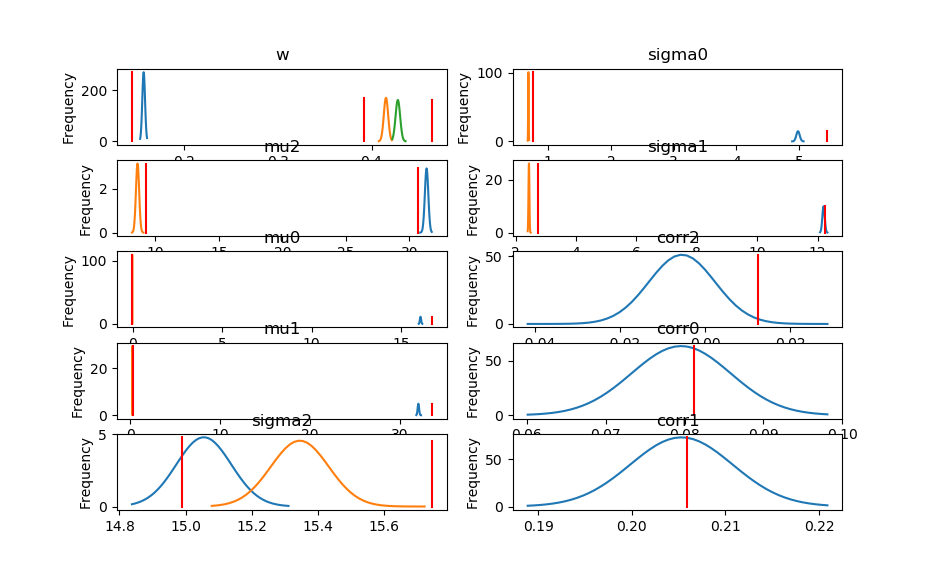

<IPython.core.display.Javascript object>


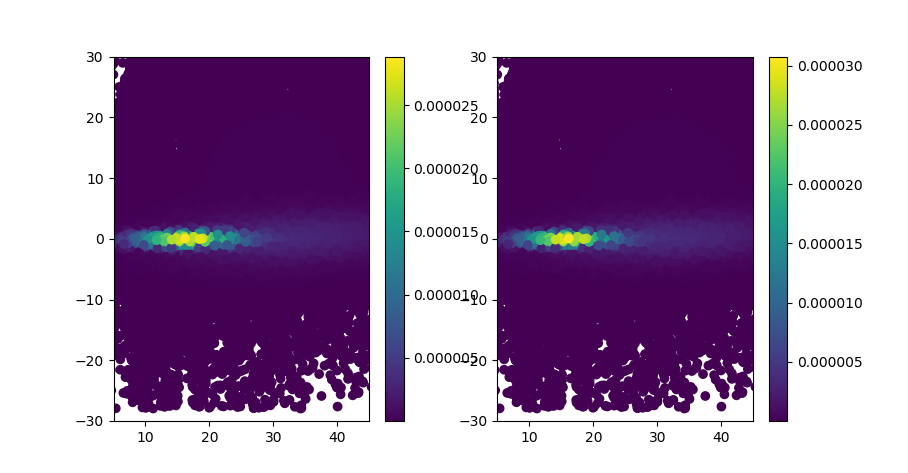

In [98]:
p.compare_1d()
prob = p.compare_2d()

<IPython.core.display.Javascript object>


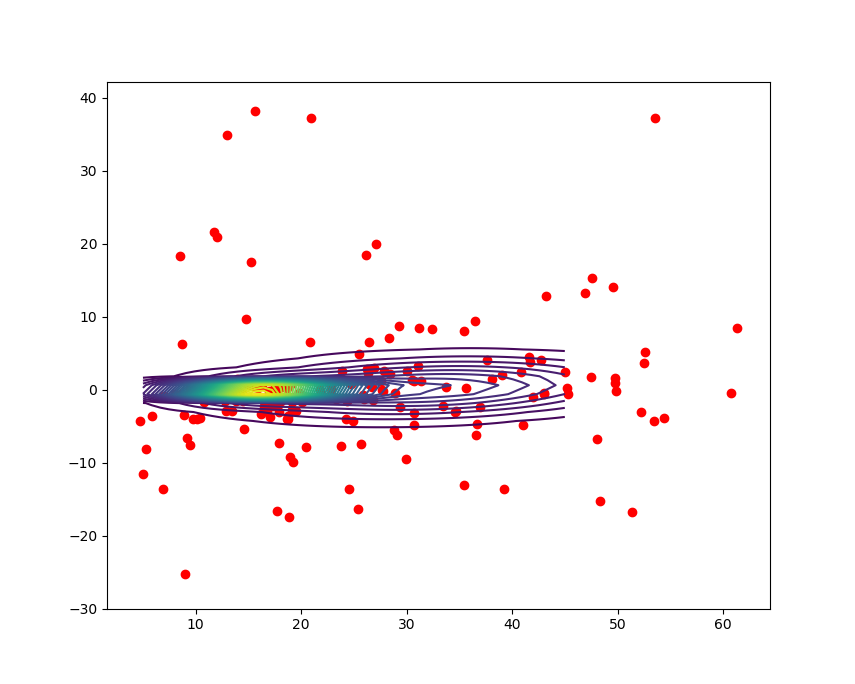

In [92]:
p.density_contour()

<IPython.core.display.Javascript object>


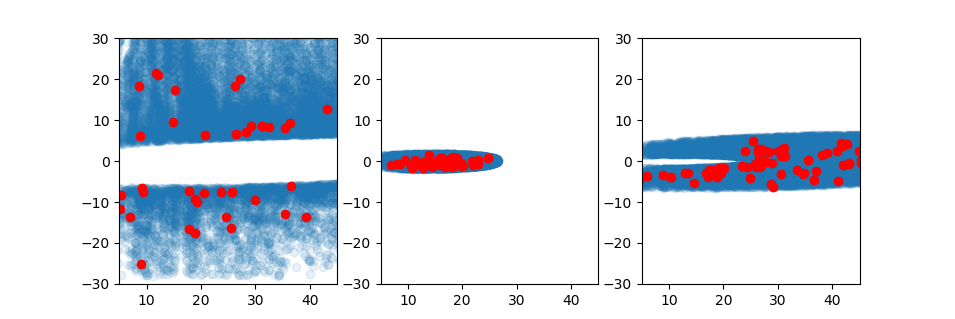

0.00048
0.00047
0.0007


In [93]:
p.maneuver()

<IPython.core.display.Javascript object>


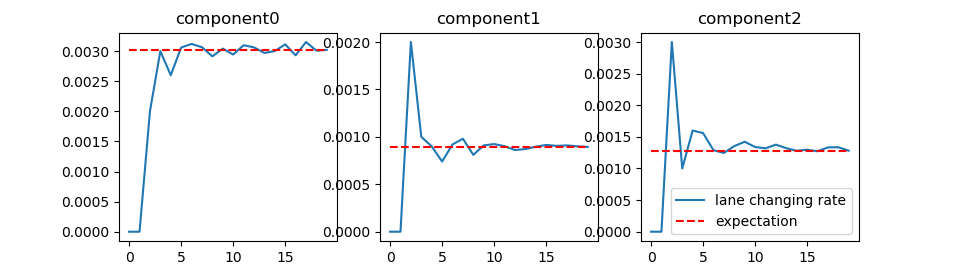

<IPython.core.display.Javascript object>


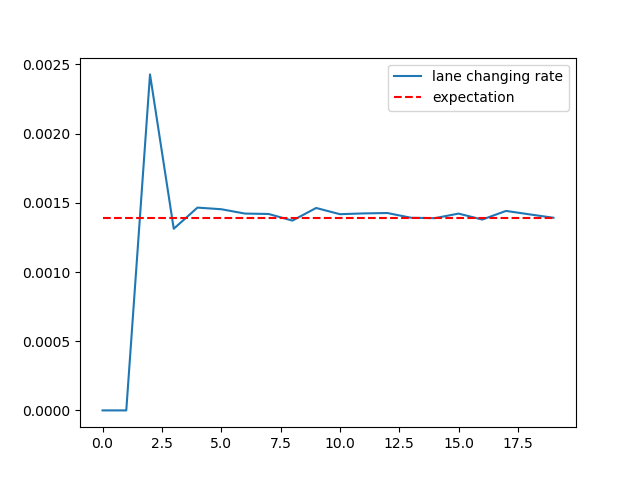

In [90]:
rate = p.importance_sampling(prob)

<IPython.core.display.Javascript object>


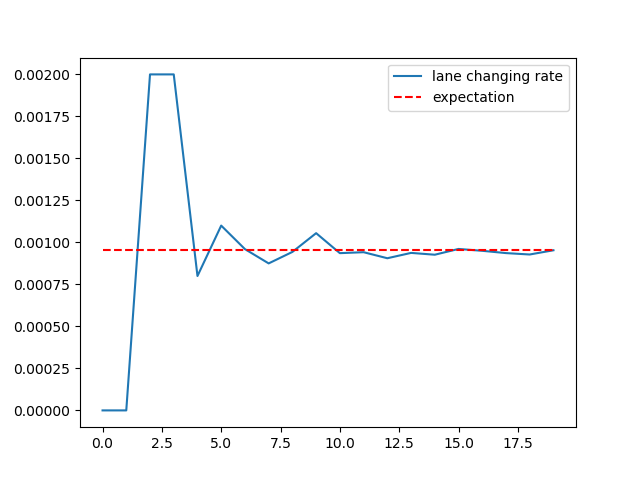

0.0009532

In [91]:
p.importance_sampling1(prob)

In [105]:
print('w')
print(p.w)
print('mu')
print(p.mu)
print('cov')
print(p.cov)

w
[0.15635346838421796, 0.41547369448069155, 0.4281728371350904]
mu
[array([31.37055219,  8.58685116]), array([16.07594691, -0.02623118]), array([32.07049176,  0.22017145])]
cov
[array([[226.64303447,  -1.25557932],
       [ -1.25557932, 235.45464822]]), array([[24.79610628,  0.27212235],
       [ 0.27212235,  0.47173604]]), array([[148.76592449,   6.11137527],
       [  6.11137527,   5.95684007]])]


In [106]:
print('w')
print(p.gmm.weights_)
print('mu')
print(p.gmm.means_)
print('cov')
print(p.gmm.covariances_)

w
[0.14387085 0.39171967 0.46440948]
mu
[[ 3.06817183e+01  9.22263875e+00]
 [ 3.35586077e+01  2.84647845e-01]
 [ 1.67037856e+01 -2.61607311e-02]]
cov
[[[224.66870286   2.9435083 ]
  [  2.9435083  247.84105342]]

 [[150.30942164   6.89497261]
  [  6.89497261   7.46105338]]

 [[ 29.6799886    0.33511414]
  [  0.33511414   0.57475619]]]
